In [ ]:
import scanpy as sc
import pandas as pd
from matplotlib import pylab
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools
import plotly.express as px
import yaml
import PyWGCNA


import numpy as np
import random
import anndata as ad
from scipy.sparse import  csr_matrix, issparse
from scipy import sparse

from matplotlib.colors import TwoSlopeNorm

import scanpy.external as sce
import sys



In [ ]:
import anndata

from pathlib import Path
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = os.path.basename(globals()["__vsc_ipynb_file__"])
    print(nb_fname)

In [ ]:

pylab.rcParams['figure.figsize'] = (9, 9)
homeDir = os.getenv("HOME")
sys.path.insert(1, homeDir+"/utils/")

from PlotPCA_components import *
from _plotResiduals import *

from AtlasClasses import *
from PurgeAdata import *

DS="androgen_substudy"


with open(homeDir+"/utils/ReferenceDict.yaml", 'r') as file:
    ReferencePaths = yaml.safe_load(file)
    for k in list(ReferencePaths.keys()):
        ReferencePaths[k]["adataPath"] = "/group/testa/Users/davide.castaldi/Polaroids_spinoff"+ReferencePaths[k]["adataPath"]
        #ReferencePaths[k]["signaturePath"] = homeDir+ReferencePaths[k]["signaturePath"]
        ReferencePaths[k]["signaturePath"] = "/group/testa/Users/davide.castaldi/Polaroids_spinoff"+ReferencePaths[k]["signaturePath"]
        ReferencePaths[k]["signaturePurityPath"] = "/group/testa/Users/davide.castaldi/Polaroids_spinoff"+ReferencePaths[k]["signaturePurityPath"]


sc.settings.set_figure_params(dpi=50, facecolor='white', dpi_save=500)
pylab.rcParams['figure.figsize'] = (6, 6)
dir_path = homeDir+"/adatas/{}_ByMacroCelltype".format(DS)



def sanitize_strings(value):
    if isinstance(value, str):  # Only process string values
        return (
            value.replace('_', '')  # Replace underscores with spaces
            .replace('-', '')      # Replace hyphens with spaces
            .replace('@', '')       # Example: Remove "@" character
        )
    return value  # Leave non-strings untouched



In [ ]:
figDir = "./figures"
os.makedirs(figDir, exist_ok=True)

# Import

In [ ]:

sexDict = {'CTL04E':'F', 'CTL01A':'F', 'CTL08A':'M', 'CTL02A':'M'}

In [ ]:
# CTL01A = F
# ctl02a = M
# ctl08a = M
# ctl04e = F


In [ ]:
pcs=15
n_neighbors=30
control = "DMSO"
prop = .2

colorDict = {"3PBA":["#FFFFFF","#9D9D9C","#1D1D1B"],
"DPHP":["#FFFFFF","#E3D5EA","#8F4A97"],
"BPA":["#FFFFFF","#D8AF59","#6B3010"],
"MEP":["#FFFFFF","#E1AED1","#B81A5D"],
"BPF":["#FFFFFF","#FFED00","#FBBA00"],
"MBzP":["#FFFFFF","#B9E0E4","#2C509F"],
"TCP":["#FFFFFF","#D3D800","#009640"],
"MIX":["#FFFFFF","#F28F83","#E52423"]}




In [ ]:
adata = sc.read_h5ad("../adatas/6.1.Annotated.{}.h5ad".format(DS))
adata

In [ ]:
sc.pl.umap(adata, color=["line","condition"], size=10, vmin='p1', vmax='p99')

In [ ]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
pd.DataFrame.iteritems = pd.DataFrame.items

anndata2ri.activate()
%reload_ext rpy2.ipython

In [ ]:
# Prepare design

design_df = adata.obs[["sample_id","line","condition"]].copy()
design_df = design_df.applymap(sanitize_strings).loc[adata.obs_names]
pd.crosstab(design_df["sample_id"],design_df["condition"])
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['sample_id']
design_df.index.name = None


# prewpare adata
adataMilo = adata.copy()
adataMilo.obsp = None
del adataMilo.uns["neighbors"]
del adataMilo.layers
del adataMilo.varm
adataMilo.obsm["X_pca"] = adataMilo.obsm["X_pca_harmony"].copy()
del adataMilo.obsm["X_pca_harmony"]
adataMilo.obs = adataMilo.obs.applymap(sanitize_strings).loc[adataMilo.obs_names]
adataMilo.obs


In [ ]:
design_df["Sex"] = design_df.line.replace(sexDict)
design_df["Condition_Sex"] = design_df["condition"].astype(str) + "_" + design_df["Sex"].astype(str)

# R env init

In [ ]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
pd.DataFrame.iteritems = pd.DataFrame.items

anndata2ri.activate()
%reload_ext rpy2.ipython

In [ ]:
%%R  -i adataMilo -w 800 -h 600 -r 300 -i control -i pcs -i n_neighbors  -i prop -i design_df

library(miloR)
library(igraph)
library(ggraph)

library(ggplot2)
library(dplyr)

set.seed(1)



# Agonist VS DMSO

In [ ]:
%%R -i design_df -o results -o neighbrsMap -o obsNames



d=pcs
k=n_neighbors

set.seed(1)

results <- list()
neighbrsMap <- list()
obsNames <- list()





rownames(design_df) <- design_df$sample_id
print(design_df)

# Take the contrast relevant anndata slice
SCE <- adataMilo
colData(SCE) <- DataFrame(lapply(colData(SCE), as.character), row.names = rownames(colData(SCE)))
milo <- Milo(SCE)
obsNames <- colnames(milo)
milo <- buildGraph(milo, k=k, d=d, reduced.dim='PCA')
milo <- makeNhoods(milo, prop=prop, k=k, d=d, refined = TRUE,refinement_scheme="graph",reduced_dims ="PCA")
milo <- countCells(milo, meta.data = data.frame(colData(milo)), samples="sample_id")
neighbrsMap <- milo@nhoods

# Prepare contrasts
design_df$condition <- factor(
design_df$condition,
levels = unique(design_df$condition)[
    order(!grepl("DMSO", unique(design_df$condition)))
]
)
design_df <- distinct(design_df)
print(design_df)

# Isolate the non-reference condition



results <- testNhoods(
milo, 
design = ~ line + condition, 
design.df = design_df,
reduced.dim = 'PCA',fdr.weighting="graph-overlap"
)

# Plotting
milo <- buildNhoodGraph(milo)


# Print the plot
theme(
panel.background = element_rect(fill = "transparent", colour = NA_character_),
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(),
plot.background = element_rect(fill = "transparent", colour = NA_character_),
legend.background = element_rect(fill = "transparent"),
legend.text = element_text(size = 3),
legend.title = element_text(size = 3),
legend.key.size = unit(0.2, "cm"),        # reduce size of legend keys
legend.spacing = unit(0.1, "cm"),         # reduce spacing between keys
legend.margin = margin(0.1, 0.1, 0.1, 0.1, "cm"),  # tighten legend box
plot.title = element_text(hjust = 0.5, size = 3)
)



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[1] "value"


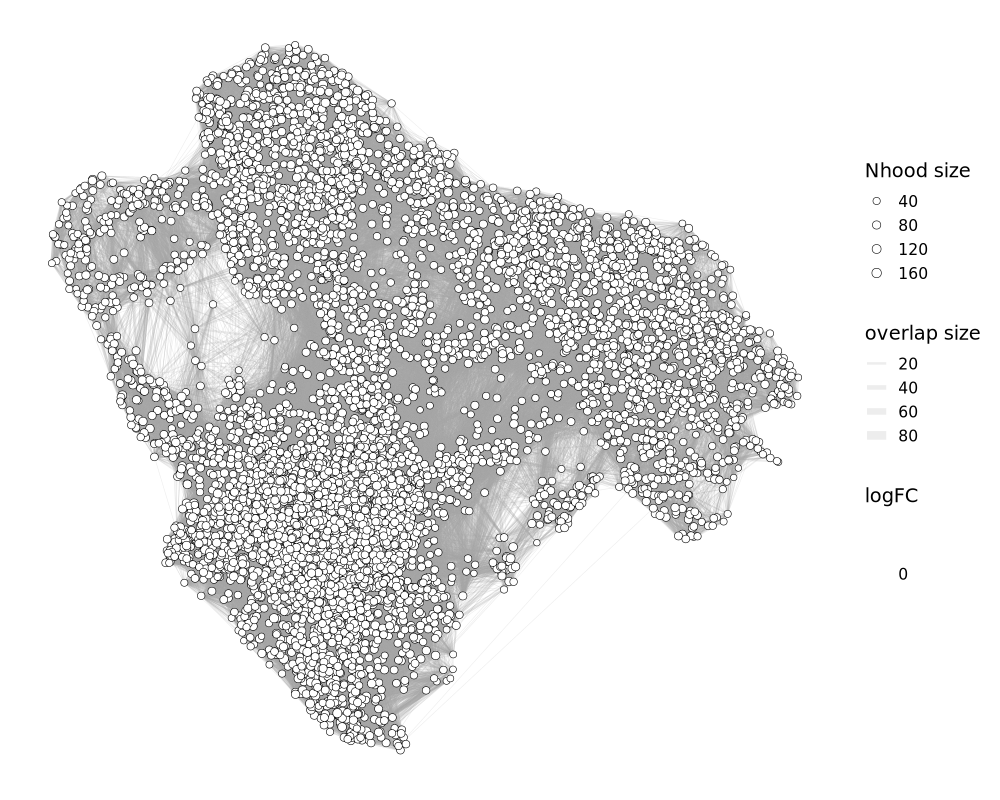

In [25]:
%%R -w 1000 -h 800 -r 100




plot <- plotNhoodGraphDA(milo, results,  alpha = 0.05,size_range=c(2,3), layout="UMAP")+
  scale_fill_gradient2(high='#be1622', mid='white', low="#534ca3", name="logFC")+ theme(
  panel.background = element_rect(fill = "transparent",
                                  colour = NA_character_), # necessary to avoid drawing panel outline
  panel.grid.major = element_blank(), # get rid of major grid
  panel.grid.minor = element_blank(), # get rid of minor grid
  plot.background = element_rect(fill = "transparent",
                                 colour = NA_character_), # necessary to avoid drawing plot outline
  legend.background = element_rect(fill = "transparent"),
)

print(plot)


In [26]:
%%R -i figDir
ggsave(
  paste0(figDir,"/DA.logFC.AgonistVsDMSO.png"),
  plot = last_plot(),
  device = "png",
  scale = 1,bg = "transparent",
  width = 2200,
  height = 1640,
  units = c("px"),
  dpi = 300)

[1] "value"


# Differential M - F effect

In [28]:
%%R -i design_df



d=pcs
k=n_neighbors

set.seed(1)

results <- list()
neighbrsMap <- list()
obsNames <- list()





rownames(design_df) <- design_df$sample_id
print(design_df)

# Take the contrast relevant anndata slice
SCE <- adataMilo
colData(SCE) <- DataFrame(lapply(colData(SCE), as.character), row.names = rownames(colData(SCE)))
milo <- Milo(SCE)
obsNames <- colnames(milo)
milo <- buildGraph(milo, k=k, d=d, reduced.dim='PCA')
milo <- makeNhoods(milo, prop=prop, k=k, d=d, refined = TRUE,refinement_scheme="graph",reduced_dims ="PCA")
milo <- countCells(milo, meta.data = data.frame(colData(milo)), samples="sample_id")
neighbrsMap <- milo@nhoods

# Prepare contrasts
design_df$condition <- factor(
design_df$condition,
levels = unique(design_df$condition)[
    order(!grepl("DMSO", unique(design_df$condition)))
]
)

design_df <- distinct(design_df)

print(design_df)


# Isolate the non-reference condition


results <- testNhoods(
milo, 
design = ~ 0 + Condition_Sex, 
design.df = design_df, model.contrasts = c("(Condition_SexANDROGENAGONIST_M-Condition_SexDMSO_M)-(Condition_SexANDROGENAGONIST_F-Condition_SexDMSO_F)"),
reduced.dim = 'PCA',fdr.weighting="graph-overlap"
)

# Plotting
milo <- buildNhoodGraph(milo)



            sample_id   line       condition Sex     Condition_Sex
1CTL04E393 1CTL04E393 CTL04E            DMSO   F            DMSO_F
1CTL01A393 1CTL01A393 CTL01A            DMSO   F            DMSO_F
1CTL08A393 1CTL08A393 CTL08A            DMSO   M            DMSO_M
1CTL02A393 1CTL02A393 CTL02A            DMSO   M            DMSO_M
1CTL08A394 1CTL08A394 CTL08A ANDROGENAGONIST   M ANDROGENAGONIST_M
1CTL04E394 1CTL04E394 CTL04E ANDROGENAGONIST   F ANDROGENAGONIST_F
1CTL01A394 1CTL01A394 CTL01A ANDROGENAGONIST   F ANDROGENAGONIST_F
1CTL02A394 1CTL02A394 CTL02A ANDROGENAGONIST   M ANDROGENAGONIST_M


R[write to console]: Constructing kNN graph with k:30

R[write to console]: Checking valid object

R[write to console]: Running refined sampling with graph

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods



            sample_id   line       condition Sex     Condition_Sex
1CTL04E393 1CTL04E393 CTL04E            DMSO   F            DMSO_F
1CTL01A393 1CTL01A393 CTL01A            DMSO   F            DMSO_F
1CTL08A393 1CTL08A393 CTL08A            DMSO   M            DMSO_M
1CTL02A393 1CTL02A393 CTL02A            DMSO   M            DMSO_M
1CTL08A394 1CTL08A394 CTL08A ANDROGENAGONIST   M ANDROGENAGONIST_M
1CTL04E394 1CTL04E394 CTL04E ANDROGENAGONIST   F ANDROGENAGONIST_F
1CTL01A394 1CTL01A394 CTL01A ANDROGENAGONIST   F ANDROGENAGONIST_F
1CTL02A394 1CTL02A394 CTL02A ANDROGENAGONIST   M ANDROGENAGONIST_M


R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withgraph-overlap weighting



[1] "value"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[1] "value"


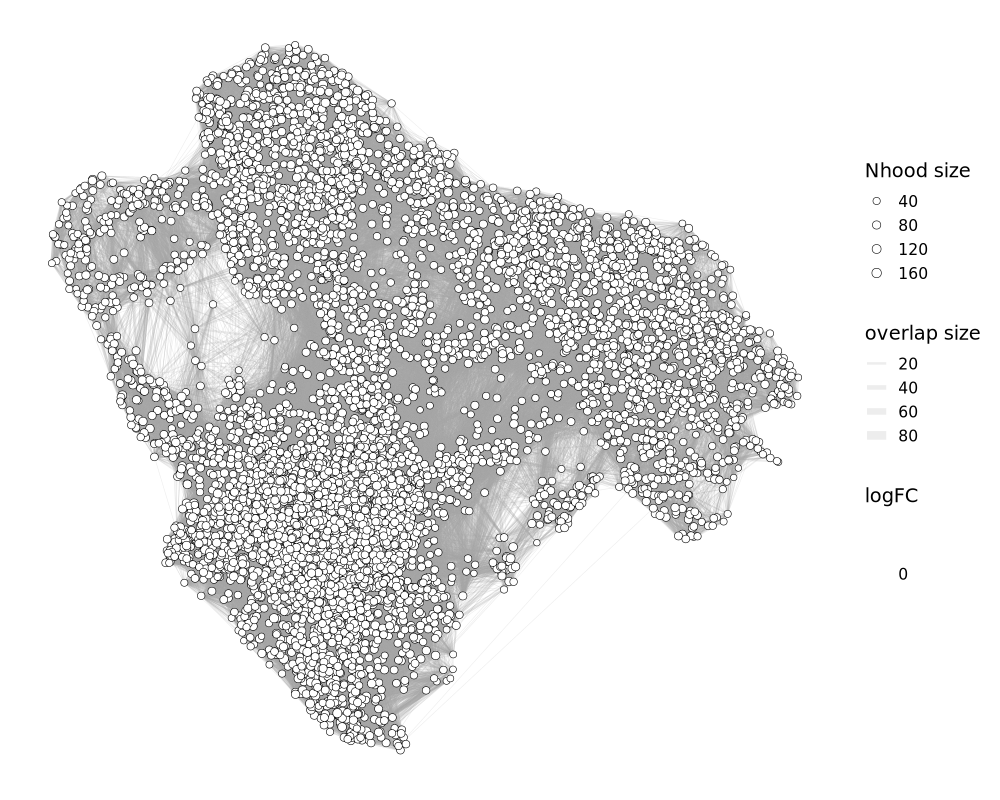

In [29]:
%%R -w 1000 -h 800 -r 100


plot <- plotNhoodGraphDA(milo, results,  alpha = 0.05,size_range=c(2,3), layout="UMAP")+
  scale_fill_gradient2(high='#be1622', mid='white', low="#534ca3", name="logFC")+ theme(
  panel.background = element_rect(fill = "transparent",
                                  colour = NA_character_), # necessary to avoid drawing panel outline
  panel.grid.major = element_blank(), # get rid of major grid
  panel.grid.minor = element_blank(), # get rid of minor grid
  plot.background = element_rect(fill = "transparent",
                                 colour = NA_character_), # necessary to avoid drawing plot outline
  legend.background = element_rect(fill = "transparent"),
)

print(plot)


In [31]:
%%R -i figDir
ggsave(
  paste0(figDir,"/DA.logFC.DifferentialMvsF.png"),
  plot = last_plot(),
  device = "png",
  scale = 1,bg = "transparent",
  width = 2200,
  height = 1640,
  units = c("px"),
  dpi = 300)

[1] "value"
